In [1]:
import os
print(os.listdir("../input"))

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm as tn

import random

['twitter-entity-sentiment-analysis']


In [2]:
train_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv'
valid_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv'
cols = ['Id', 'Entity', 'Sentiment', 'Tweet']
train = pd.read_csv(train_path, names = cols, header=None)
valid = pd.read_csv(valid_path, names = cols)
train['is_train'], valid['is_train'] = True, False
all_df = train.append(valid)
all_df

,Id,Entity,Sentiment,Tweet,is_train
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,True
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,True
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,True
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,True
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,True
...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,False
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,False
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,False
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,False


In [3]:
all_df.index = pd.RangeIndex(len(all_df.index))
all_df.index = range(len(all_df.index))
all_df

,Id,Entity,Sentiment,Tweet,is_train
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,True
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,True
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,True
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,True
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,True
...,...,...,...,...,...
75677,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,False
75678,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,False
75679,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,False
75680,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,False


## EDA

In [4]:
all_df.head(2).T

,0,1
Id,2401,2401
Entity,Borderlands,Borderlands
Sentiment,Positive,Positive
Tweet,im getting on borderlands and i will murder yo...,I am coming to the borders and I will kill you...
is_train,True,True


In [5]:
labeled_df = train[['Sentiment', 'Tweet']].copy()

labeled_df  = labeled_df[pd.notnull(labeled_df['Tweet'])]

labeled_df.shape

(73996, 2)

In [6]:
labeled_df.isnull().sum()

Sentiment    0
Tweet        0
dtype: int64

In [7]:
total = train['Tweet'].notnull().sum()
round((total/len(all_df)*100),1)

97.8

In [8]:
# pd.DataFrame(short_df.Sentiment.unique()).values
labeled_df.Sentiment.value_counts()

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: Sentiment, dtype: int64

In [9]:
labeled_df['Sentiment_target'] = labeled_df.Sentiment.factorize()[0]
# short_df=short_df[['Tweet', 'Sentiment_target']].drop_duplicates()
short_df = labeled_df.sample(35000, random_state=1).copy()
short_df

,Sentiment,Tweet,Sentiment_target
56570,Positive,Are we just going to pretend to be @ Ubisoft a...,0
54194,Negative,"The problem is even more than racism, it's a d...",2
64054,Negative,Hey @EAMaddenNFL but when else is the update c...,2
42756,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
38295,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
18029,Positive,U could hear that ps1 was in a joint.. dope......,0
29309,Negative,@EA @PlayApex I’ve been trying to play the gam...,2
29737,Neutral,I really had a bad feeling to clear ppl with t...,1
45666,Neutral,Eh. Probably for the best.,1


In [10]:
short_df=short_df.drop_duplicates()
short_df

,Sentiment,Tweet,Sentiment_target
56570,Positive,Are we just going to pretend to be @ Ubisoft a...,0
54194,Negative,"The problem is even more than racism, it's a d...",2
64054,Negative,Hey @EAMaddenNFL but when else is the update c...,2
42756,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
38295,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
18029,Positive,U could hear that ps1 was in a joint.. dope......,0
29309,Negative,@EA @PlayApex I’ve been trying to play the gam...,2
29737,Neutral,I really had a bad feeling to clear ppl with t...,1
45666,Neutral,Eh. Probably for the best.,1


In [11]:
short_df = short_df.reset_index(drop=True)
short_df

,Sentiment,Tweet,Sentiment_target
0,Positive,Are we just going to pretend to be @ Ubisoft a...,0
1,Negative,"The problem is even more than racism, it's a d...",2
2,Negative,Hey @EAMaddenNFL but when else is the update c...,2
3,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
4,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
33672,Positive,U could hear that ps1 was in a joint.. dope......,0
33673,Negative,@EA @PlayApex I’ve been trying to play the gam...,2
33674,Neutral,I really had a bad feeling to clear ppl with t...,1
33675,Neutral,Eh. Probably for the best.,1


In [12]:
np.nonzero((short_df.Sentiment_target==3).values)

(array([    3,     7,    13, ..., 33663, 33666, 33667]),)

In [13]:
for i in np.nonzero((short_df.Sentiment_target==3).values):
    short_df.Sentiment_target[i] = int(1)
short_df.Sentiment_target.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1    14173
2    10184
0     9320
Name: Sentiment_target, dtype: int64

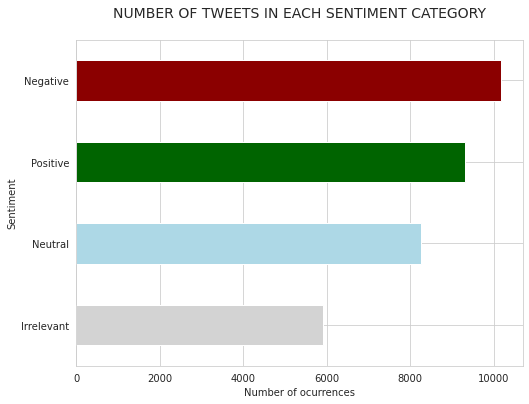

In [14]:
fig = plt.figure(figsize=(8,6))
colors = ['lightgrey','lightblue','darkgreen', 'darkred']
short_df.groupby(['Sentiment']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH SENTIMENT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

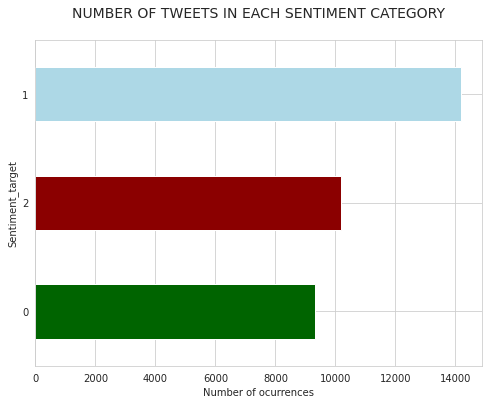

In [15]:
fig = plt.figure(figsize=(8,6))
colors = ['darkgreen', 'darkred', 'lightblue']
short_df.groupby(['Sentiment_target']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH SENTIMENT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

## Text Preprocessing

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(short_df.Tweet).toarray()

labels = short_df.Sentiment_target

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 33677 tweets is represented by 14348 features (TF-IDF score of unigrams and bigrams)


In [17]:
labels

0        0
1        2
2        2
3        1
4        2
        ..
33672    0
33673    2
33674    1
33675    1
33676    0
Name: Sentiment_target, Length: 33677, dtype: int64

## Split data

In [18]:
X = short_df['Tweet'] 
y = short_df['Sentiment_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [19]:
X_train

10470    So shit went sideways with  . . twitch.tv/sa7a...
27382    Judge blocks Microsoft's Pentagon contract aft...
21013    Interesting... (for real, Jessica is pretty aw...
11684    U could hear this PS1 sound in this joint.. do...
25306    Borderlands 3 Chapter 1 youtu.be / 0SKu6Vr4iXU...
                               ...                        
20757    I appreciate how my favorite sniper stays on t...
32103                                             music . 
30403    Kena is named one in my top 5 most anticipated...
21243    After questionable recent actions, I've really...
2732                                          ... Shut up.
Name: Tweet, Length: 25257, dtype: object

## Building models: RandomForest, LinearSVM, MultinomialNB, LogRegression

In [20]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, verbose=1),
    LinearSVC(verbose=1),
    MultinomialNB(),
    LogisticRegression(random_state=0,verbose=1),
]

In [21]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in tn(models):
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

  0%|          | 0/4 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[LibLinear].....*
optimization finished, #iter = 51
Objective value = -7601.905350
nSV = 18159
.....*
optimization finished, #iter = 51
Objective value = -9751.443377
nSV = 21201
....*.
optimization finished, #iter = 50
Objective value = -6923.355972
nSV = 17460
[LibLinear].....*
optimization finished, #iter = 51
Objective value = -7742.776306
nSV = 18385
....*.
optimization finished, #iter = 50
Objective value = -9761.365051
nSV = 21260
....*.
optimization finished, #iter = 50
Objective value = -6941.475694
nSV = 17356
[LibLinear]....*.
optimization finished, #iter = 50
Objective value = -7726.085421
nSV = 18468
.....*
optimization finished, #iter = 51
Objective value = -9871.445513
nSV = 21348
....*.
optimization finished, #iter = 50
Objective value = -7035.370240
nSV = 17567
[LibLinear].....*
optimization finished, #iter = 51
Objective value = -7774.913294
nSV = 18420
.....*
optimization finished, #iter = 51
Objective value = -9898.363767
nSV = 21333
....*.
optimization finished, #i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        43047     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95977D+04    |proj g|=  2.35767D+03

At iterate   50    f=  1.69984D+04    |proj g|=  6.29039D+01

At iterate  100    f=  1.68935D+04    |proj g|=  1.05131D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
43047    100    111      1     0     0   1.051D+01   1.689D+04
  F =   16893.453757012674     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        43047     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95977D+04    |proj g|=  2.35767D+03


 This problem is unconstrained.



At iterate   50    f=  1.70068D+04    |proj g|=  2.84529D+01

At iterate  100    f=  1.69412D+04    |proj g|=  2.52823D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
43047    100    117      1     0     0   2.528D+00   1.694D+04
  F =   16941.163475536974     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        43047     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95988D+04    |proj g|=  2.35833D+03


 This problem is unconstrained.



At iterate   50    f=  1.72785D+04    |proj g|=  2.91217D+01

At iterate  100    f=  1.70644D+04    |proj g|=  4.67407D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
43047    100    112      1     0     0   4.674D+00   1.706D+04
  F =   17064.388321862596     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        43047     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95988D+04    |proj g|=  2.35833D+03


 This problem is unconstrained.



At iterate   50    f=  1.71781D+04    |proj g|=  4.48982D+01

At iterate  100    f=  1.70333D+04    |proj g|=  8.62855D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
43047    100    115      1     0     0   8.629D+00   1.703D+04
  F =   17033.283688430423     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        43047     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95988D+04    |proj g|=  2.35733D+03


 This problem is unconstrained.



At iterate   50    f=  1.71069D+04    |proj g|=  1.36373D+02

At iterate  100    f=  1.70057D+04    |proj g|=  9.77222D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
43047    100    110      1     0     0   9.772D+00   1.701D+04
  F =   17005.664790110150     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

## Evaluate

In [22]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.808297,0.008125
LogisticRegression,NaN,NaN
MultinomialNB,0.738665,0.008320
RandomForestClassifier,0.424147,0.001681


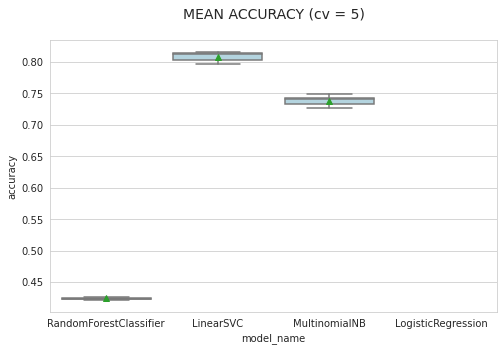

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);


In [24]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               short_df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [25]:
y_test = y_test.reset_index(drop=True)
y_test, y_pred

(0       0
 1       1
 2       2
 3       2
 4       1
        ..
 8415    0
 8416    2
 8417    1
 8418    2
 8419    1
 Name: Sentiment_target, Length: 8420, dtype: int64,
 array([1, 1, 2, ..., 1, 1, 1]))

In [26]:
len(y_test),len(y_pred)

(8420, 8420)

In [27]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names=['Positive','Negative', 'Neutral']))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    Positive       0.79      0.75      0.77      2274
    Negative       0.80      0.83      0.81      3598
     Neutral       0.82      0.81      0.81      2548

    accuracy                           0.80      8420
   macro avg       0.80      0.80      0.80      8420
weighted avg       0.80      0.80      0.80      8420



## Confusion Matrix

In [28]:
!git clone https://github.com/DTrimarchi10/confusion_matrix

Cloning into 'confusion_matrix'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), 119.69 KiB | 3.32 MiB/s, done.


In [29]:
url = f"https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py"
!wget --no-cache --backups=1 {url}
import subprocess
result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
print(result.stderr.decode("utf-8"))

--2022-02-20 21:17:24--  https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4088 (4.0K) [text/plain]
Failed to rename cf_matrix.py to cf_matrix.py.1: (2) No such file or directory
Saving to: ‘cf_matrix.py’

cf_matrix.py        100%[===================>]   3.99K  --.-KB/s    in 0s      

2022-02-20 21:17:25 (36.0 MB/s) - ‘cf_matrix.py’ saved [4088/4088]

--2022-02-20 21:17:25--  https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connecte

In [30]:
from cf_matrix import make_confusion_matrix
sns.set_context('talk')

In [31]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[1702,  420,  152],
       [ 315, 2994,  289],
       [ 148,  348, 2052]])

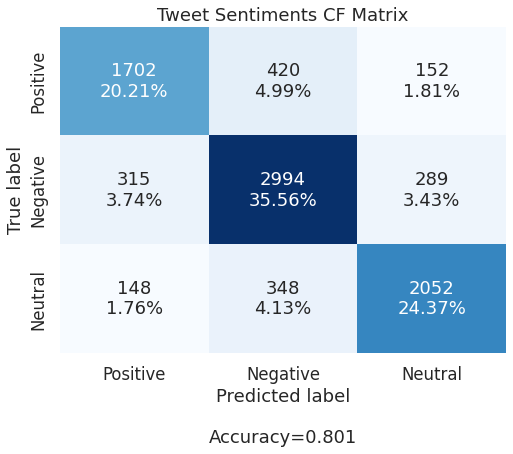

In [32]:
categories = ['Positive','Negative', 'Neutral']
make_confusion_matrix(conf_mat, figsize=(8,6), cbar=False,categories = categories, title='Tweet Sentiments CF Matrix')

## Predictions

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [34]:
new_tweet = valid.Tweet[random.randint(0, len(valid.Tweet))]
print(new_tweet)

Former Arsenal and West Ham player Alex Song has taken his case to FIFA after being sacked by FC Sion.

The 32-year-old was one of nine players to lose his job when the Swiss side proposed reducing the wage bill of the first team as an emergency measure during the coronavirus


In [35]:
model.predict(fitted_vectorizer.transform([new_tweet]))

array([1])

In [36]:
valid[valid['Tweet'] == new_tweet]

,Id,Entity,Sentiment,Tweet,is_train
915,6055,FIFA,Irrelevant,Former Arsenal and West Ham player Alex Song h...,False
